In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tensorflow_probability.substrates import jax as tfp
from tqdm import tqdm
from chex import PRNGKey, Array
from typing import Dict

from reinforced_lib import RLib
from reinforced_lib.exts import BaseExt, observation, parameter
from reinforced_lib.agents.mab import UCB, EGreedy, Softmax
from reinforced_lib.agents import BaseAgent

tfd = tfp.distributions

In [17]:
def plot_resuls(results_dict: Dict, scatter: bool = True):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    for agent_name, result in results_dict.items():
        n_steps = len(result['actions'])
        if scatter:
            ax[0].scatter(range(n_steps), result['actions'], label=agent_name, s=1, alpha=0.75)
            ax[1].scatter(range(n_steps), result['rewards'], label=agent_name, s=1, alpha=0.75)
        else:
            ax[0].plot(range(n_steps), result['actions'], label=agent_name)
            ax[1].plot(range(n_steps), result['rewards'], label=agent_name)
    ax[0].set_title('Actions')
    ax[1].set_title('Rewards')
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [7]:
class GUPBExt(BaseExt):
    """
    Reinforced-lib extension for tunnig R2D2s parameters in GUPB.
    This extension can be used with Multi-Armed Bandit (MAB) algorithms.
    """

    def __init__(self, n_arms: int) -> None:
        super().__init__()
        self.n = n_arms

    observation_space = gym.spaces.Dict({})

    @parameter(parameter_type=gym.spaces.Box(1, np.inf, (1,), np.int32))
    def n_arms(self) -> int:
        return self.n

    @observation(observation_type=gym.spaces.Box(-np.inf, np.inf, (1,)))
    def reward(self, reward, *args, **kwargs) -> float:
        return reward

In [75]:
def run_agent(agent: RLib, rewards: Array, n_steps: int, key: PRNGKey):
    
    act = 0
    act_acc = [act]
    reward_acc = [rewards[act].sample(seed=key)]
    for _ in tqdm(range(n_steps)):
        key, subkey = jax.random.split(key)
        act = agent.sample(reward_acc[-1])
        act_acc.append(act)
        reward_acc.append(jnp.clip(rewards[act].sample(seed=subkey), 0.))
    
    return act_acc, reward_acc

In [85]:
rewards = [
    tfd.Normal(loc=i, scale=10.) for i in [2, 4, 12, 23, 41]
]

In [143]:
agents = {
    # 'EGreedy': RLib(
    #     agent_type=EGreedy,
    #     agent_params={'e': 0.166, 'optimistic_start': 1000.0},
    #     ext_type=GUPBExt,
    #     ext_params={'n_arms': len(rewards)}
    # ),
    # 'Softmax': RLib(
    #     agent_type=Softmax,
    #     agent_params={'lr': 1., 'tau': 25., 'multiplier': 0.01},
    #     ext_type=GUPBExt,
    #     ext_params={'n_arms': len(rewards)}
    # ),
    'UCB': RLib(
        agent_type=UCB,
        agent_params={'c': 100},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    )
}

100%|██████████| 1000/1000 [00:00<00:00, 1270.99it/s]


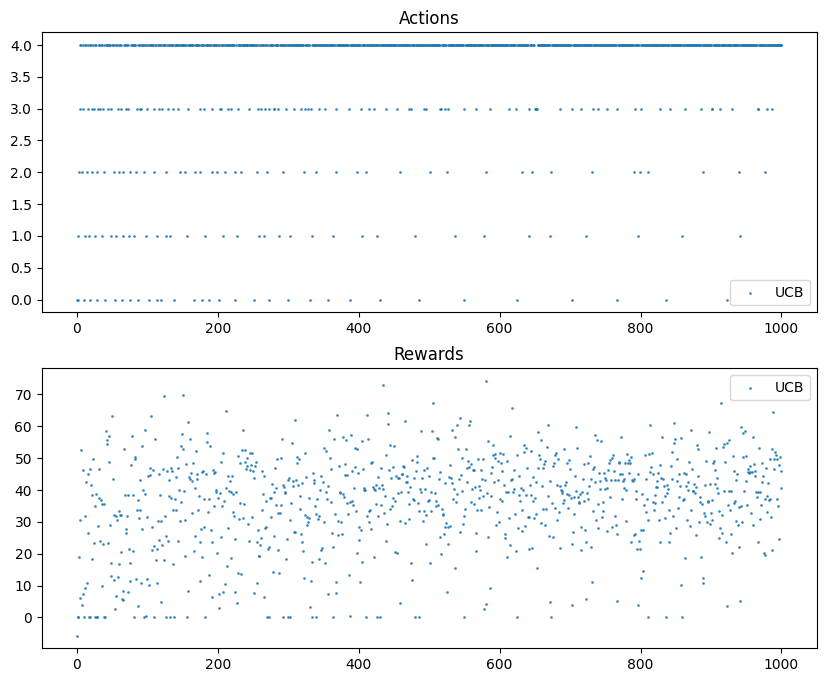

In [144]:
results_dict = {}
n_steps = 1000
for agent_name, agent in agents.items():
    key = jax.random.PRNGKey(324)
    act_acc, reward_acc = run_agent(agent, rewards, n_steps, key)
    results_dict[agent_name] = {
        "actions": act_acc,
        "rewards": reward_acc
    }

plot_resuls(results_dict)

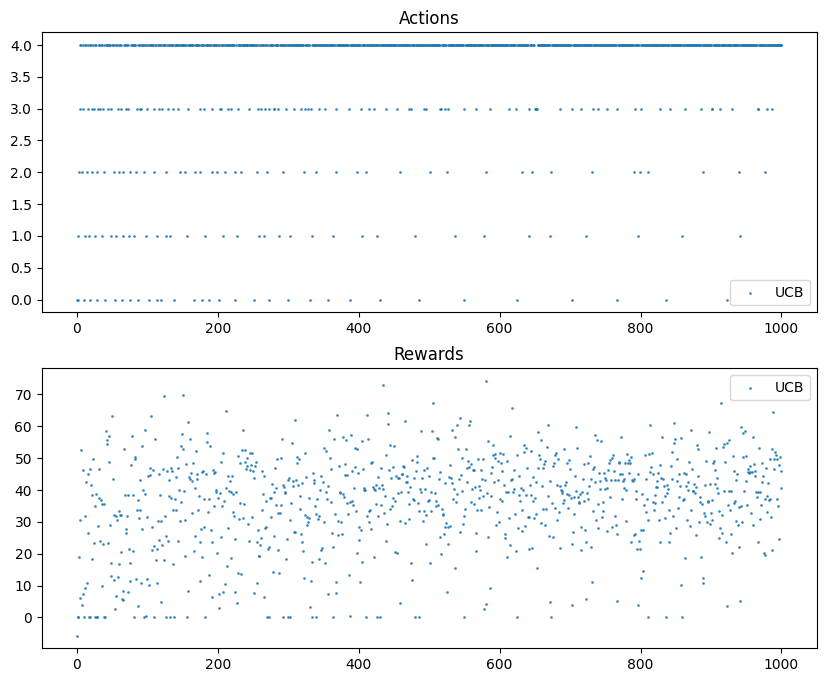

In [132]:
plot_resuls(results_dict)

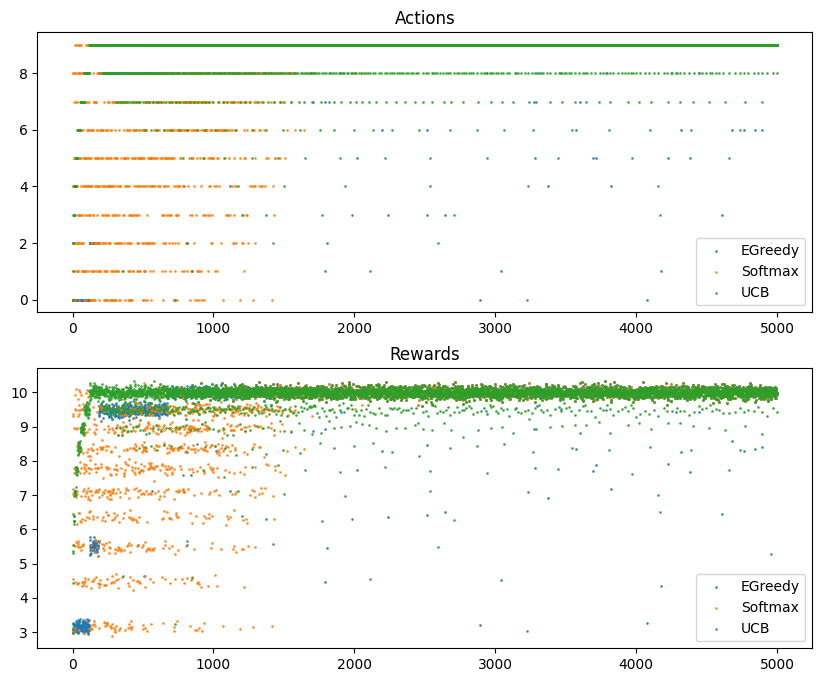

In [13]:
plot_resuls(results_dict)